In [29]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Carregar modelo
# Use 'weights' instead of 'pretrained' as it is deprecated
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# Hook para capturar gradientes
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

# Registrar hooks na última camada convolucional
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Transformação da imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Carregar imagem
img_path = 'exemplo.jpg'  # Substituir pelo arquivo

try:
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0)

    # Forward
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Backward
    model.zero_grad()
    output[0, pred_class].backward()

    # Grad-CAM
    grad = gradients[0]
    act = activations[0]
    weights = grad.mean(dim=[2, 3], keepdim=True)
    cam = (weights * act).sum(dim=1).squeeze()
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    cam_np = cam.cpu().numpy()
    cam_np = cv2.resize(cam_np, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)

    # Sobrepor na imagem original
    img_np = np.array(img.resize((224, 224)))
    overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

    # Mostrar resultado
    plt.imshow(overlay)
    plt.title(f'Grad-CAM - Classe Predita: {pred_class}')
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"Erro: '{img_path}' not found. Please upload the image file.")
except Exception as e:
    print(f"An error occurred: {e}")

Erro: 'exemplo.jpg' not found. Please upload the image file.


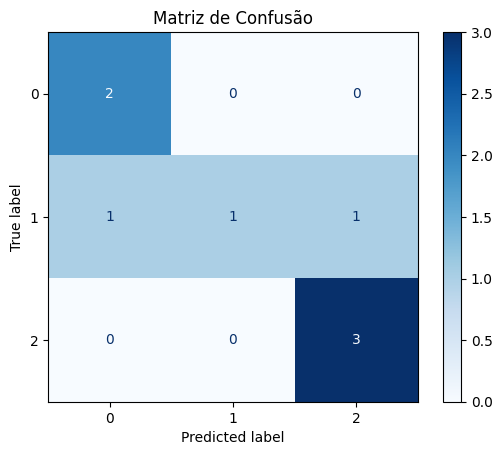

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Exemplo: classes reais e preditas
y_true = [0, 1, 2, 2, 0, 1, 1, 2]
y_pred = [0, 2, 2, 2, 0, 1, 0, 2]

# Gerar matriz
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()
